In [1]:

import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'
import shutil

import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
import re
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import Dense, Flatten, Softmax
from keras.preprocessing.image import load_img
print(tf.__version__)

2.8.0


## Image Folder Location

In [2]:
pathname='/Users/seanoconnor/Downloads/imgs/euro'

# Split to Train Validate

In [3]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    pathname,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    pathname,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 135 files belonging to 7 classes.
Using 108 files for training.
Found 135 files belonging to 7 classes.
Using 27 files for validation.


2022-04-21 17:41:07.066911: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Display Some Training Data

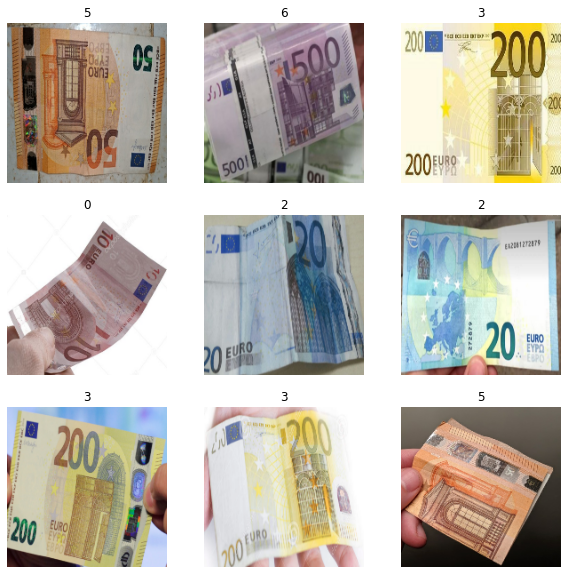

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Data Augmentation

In [14]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
    ]
)

## Model

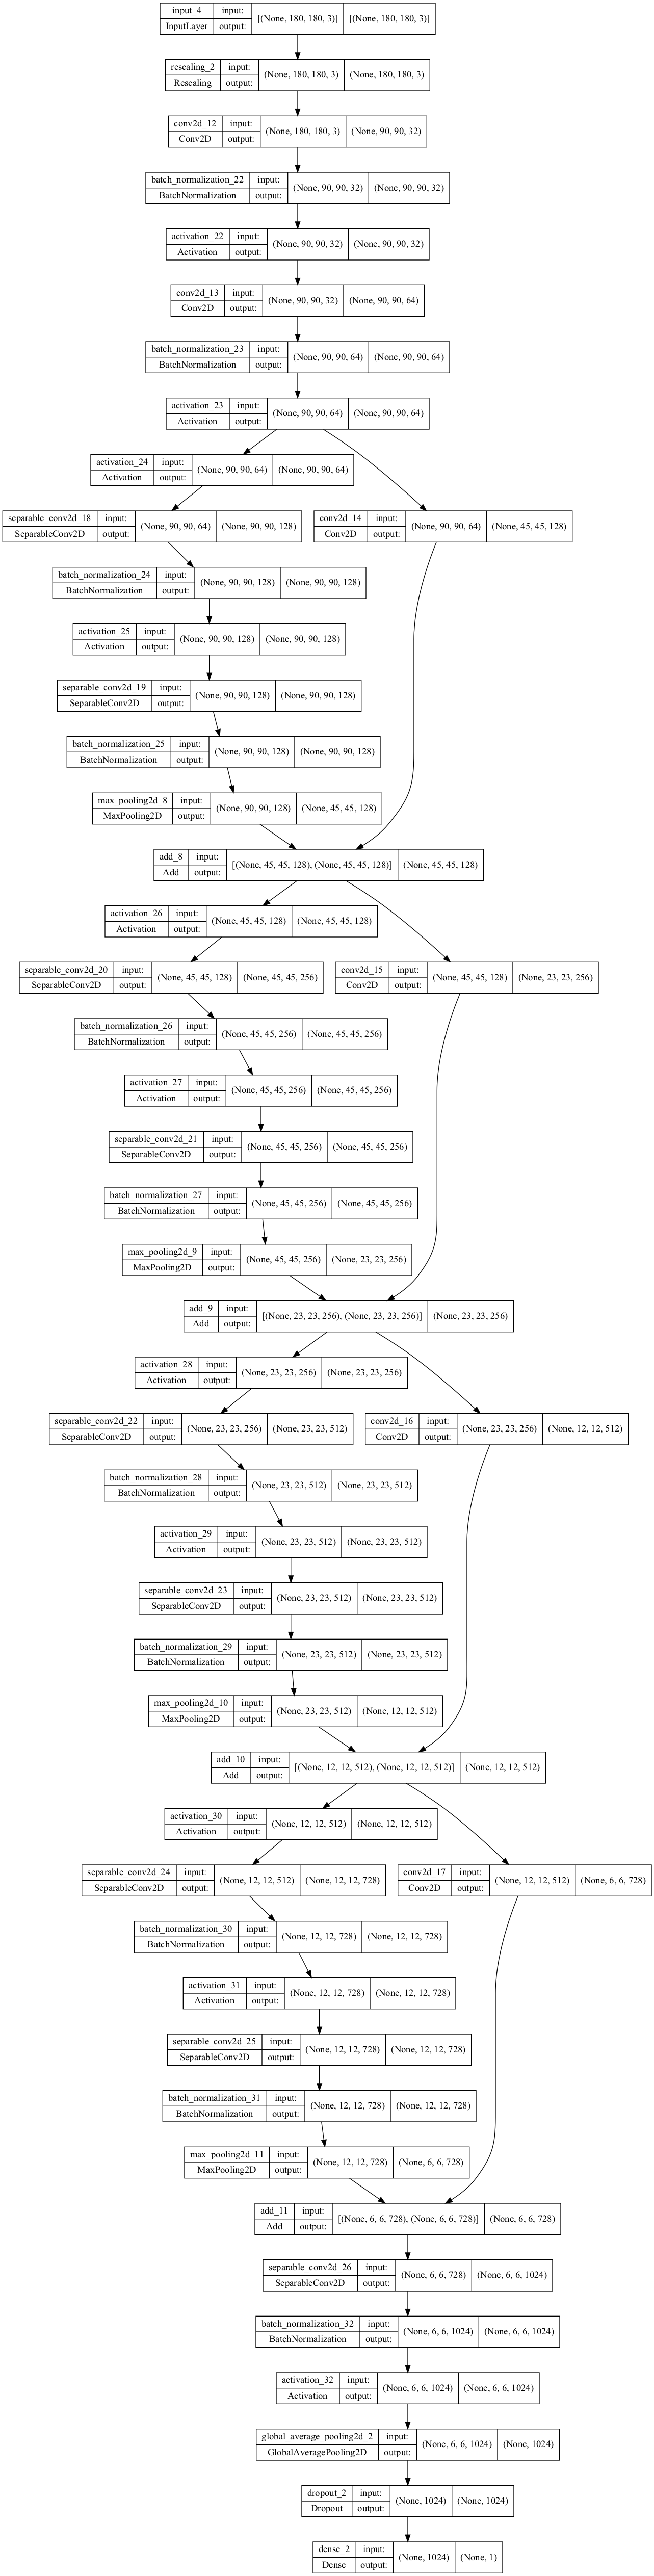

In [15]:
def make_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)
    x=inputs

    # Entry block
    x = tf.keras.layers.Rescaling(1.0 / 255)(x)
    x = tf.keras.layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.Conv2D(64, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(size, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(size, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = tf.keras.layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = tf.keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = tf.keras.layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(units, activation=activation)(x)
    return tf.keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
tf.keras.utils.plot_model(model, show_shapes=True)

In [13]:
epochs = 50

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
4/4 [==============================] - ETA: 0s - loss: -0.2804 - accuracy: 0.1296WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fd890fc8440> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and a

4/4 [==============================] - 9s 2s/step - loss: -528.2540 - accuracy: 0.1852 - val_loss: -1.4299 - val_accuracy: 0.1852
Epoch 46/50
4/4 [==============================] - 9s 2s/step - loss: -553.8549 - accuracy: 0.1852 - val_loss: -1.2495 - val_accuracy: 0.1852
Epoch 47/50
4/4 [==============================] - 9s 2s/step - loss: -562.3073 - accuracy: 0.1852 - val_loss: -1.7313 - val_accuracy: 0.1852
Epoch 48/50
4/4 [==============================] - 9s 2s/step - loss: -585.9980 - accuracy: 0.1852 - val_loss: -3.1801 - val_accuracy: 0.1852
Epoch 49/50
4/4 [==============================] - 8s 2s/step - loss: -598.1681 - accuracy: 0.1852 - val_loss: -4.5277 - val_accuracy: 0.1852
Epoch 50/50
4/4 [==============================] - 9s 2s/step - loss: -622.5200 - accuracy: 0.1852 - val_loss: -8.2170 - val_accuracy: 0.1852


## Run in New Data

In [ ]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)